In [ ]:
import pandas as pd

## 오프라인 세일즈 데이터 -> 매장별 개폐업 일자 데이터로 변환 

In [71]:
import pandas as pd

# 데이터프레임 로드
offline_sales = pd.read_csv('../assets/data/offline_offline_wkly_Hazzys_sales.csv')

# 오프라인 스토어별 개장일(Open_Store_Week0)과 폐업일(Close_Store_Week0)을 추출하여 새로운 데이터프레임 생성
offline_store_info = offline_sales[['Off.Store.Code', 'Off.Store.Name2', 'Open_Store_Week0', 'Close_Store_Week0']]

# 중복 제거를 위해 고유한 매장 정보만 추출
offline_store_info = offline_store_info.drop_duplicates()

offline_store_info.head()

,Off.Store.Code,Off.Store.Name2,Open_Store_Week0,Close_Store_Week0
0,D223,현대무역닥스골프,200701.0,202112.0
48,D230,현대무역헤지스남성,200701.0,NaN
50,D253,현대중동닥스골프,200701.0,202233.0
141,D265,신세계강남닥스골프,200701.0,202252.0
175,D275,신세계본점닥스골프,200701.0,202208.0


In [72]:
online_Wkly_HZ = pd.read_csv('../assets/data/online_Wkly.HZ.csv')

# Wk_Year별로 Sales.Actual의 합산을 구하여 온라인 매출 시계열 데이터 생성
online_sales_by_year = online_Wkly_HZ.groupby('Wk_Year')['Sales.Actual'].sum().reset_index()

In [49]:
online_sales_by_year.head()

,Wk_Year,Sales.Actual
0,201901,219852.685182
1,201902,107737.669109
2,201903,92954.728918
3,201904,110051.737891
4,201905,83874.081573


# ARIMA 분석

## ACF, PACF 확인


             Sales.Actual  New_Store  Closed_Store
Wk_Year                                           
2007-01-07       0.000000       74.0           0.0
2007-03-25       0.000000        3.0           0.0
2007-04-01       0.000000        1.0           0.0
2007-04-08       0.000000        1.0           0.0
2007-06-03       0.000000        2.0           0.0
...                   ...        ...           ...
2023-12-03  119510.410282        0.0           2.0
2023-12-10  106832.188627        1.0           0.0
2023-12-17  112875.840000        0.0           2.0
2023-12-24   98747.958227        0.0           6.0
2023-12-31   81682.452045        0.0           9.0

[442 rows x 3 columns]
ADF Statistic: -1.3344932955549615
p-value: 0.6132476217161686


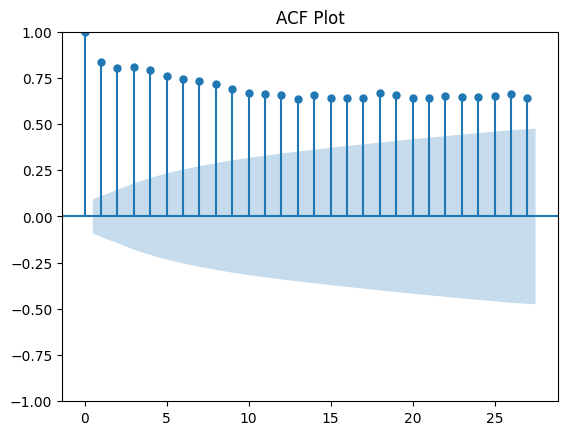

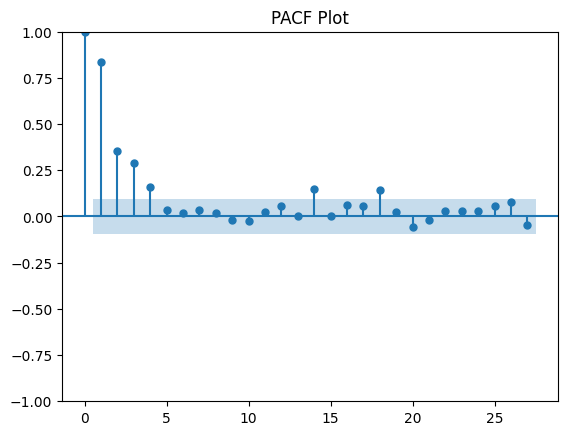

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 데이터프레임 생성 (여기서는 예시 데이터를 사용합니다)
# offline_store_info = pd.DataFrame({
#     'Off.Store.Code': ['D223', 'D230', 'D253', 'D265', 'D275'],
#     'Off.Store.Name2': ['현대무역닥스골프', '현대무역헤지스남성', '현대중동닥스골프', '신세계강남닥스골프', '신세계본점닥스골프'],
#     'Open_Store_Week0': [200701.0, 200701.0, 200701.0, 200701.0, 200701.0],
#     'Close_Store_Week0': [202112.0, np.nan, 202233.0, 202252.0, 202208.0]
# })

# online_sales_by_year = pd.DataFrame({
#     'Wk_Year': [201901, 201902, 201903, 201904, 201905],
#     'Sales.Actual': [219852.685182, 107737.669109, 92954.728918, 110051.737891, 83874.081573]
# })

# 데이터 전처리
# 개업 및 폐업 이벤트 더미 변수 생성
events = pd.DataFrame({
    'Wk_Year': [],
    'New_Store': [],
    'Closed_Store': []
})

# 개업 이벤트
for index, row in offline_store_info.iterrows():
    open_week = int(row['Open_Store_Week0'])
    closed_week = int(row['Close_Store_Week0']) if not pd.isna(row['Close_Store_Week0']) else None
    
    # 개업 주차에 이벤트 추가
    events = pd.concat([events, pd.DataFrame({'Wk_Year': [open_week], 'New_Store': [1], 'Closed_Store': [0]})], ignore_index=True)
    
    # 폐업 주차에 이벤트 추가 (존재할 경우)
    if closed_week:
        events = pd.concat([events, pd.DataFrame({'Wk_Year': [closed_week], 'New_Store': [0], 'Closed_Store': [1]})], ignore_index=True)

# 모든 이벤트 데이터프레임과 온라인 매출 데이터프레임 병합
events['Wk_Year'] = events['Wk_Year'].astype(int)
merged_data = pd.merge(online_sales_by_year, events.groupby('Wk_Year').sum().reset_index(), on='Wk_Year', how='outer').fillna(0)

# 시계열 데이터로 변환
merged_data['Wk_Year'] = pd.to_datetime(merged_data['Wk_Year'].astype(str) + '0', format='%Y%W%w')
merged_data.set_index('Wk_Year', inplace=True)

# 시계열 데이터 확인
print(merged_data)

# ADF 테스트로 정상성 확인
result = adfuller(merged_data['Sales.Actual'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# ACF 및 PACF 플롯
plot_acf(merged_data['Sales.Actual'])
plt.title('ACF Plot')
plt.show()

plot_pacf(merged_data['Sales.Actual'])
plt.title('PACF Plot')
plt.show()

## 정상성 확인 (ADF 테스트)

In [78]:
result = adfuller(merged_data['Sales.Actual'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.3344932955549615
p-value: 0.6132476217161686


### 1차 차분 => 정상 시계열 변환

In [79]:
# 1차 차분 적용
merged_data_clone = merged_data
duplicate_index = merged_data_clone.index[merged_data_clone.index.duplicated()]
merged_data_clone = merged_data_clone[~merged_data_clone.index.duplicated(keep='last')]

merged_data_clone['Sales.Actual_Diff'] = merged_data_clone['Sales.Actual'].diff().dropna()

# ADF 테스트를 다시 수행
result_diff = adfuller(merged_data_clone['Sales.Actual_Diff'].dropna())
print('ADF Statistic (Diff):', result_diff[0])
print('p-value (Diff):', result_diff[1])

ADF Statistic (Diff): -8.820102650457502
p-value (Diff): 1.8874242334021554e-14


## ARIMA 모형 사용하기

                               SARIMAX Results                                
Dep. Variable:           Sales.Actual   No. Observations:                  442
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5148.243
Date:                Wed, 09 Oct 2024   AIC                          10306.487
Time:                        20:53:21   BIC                          10326.932
Sample:                             0   HQIC                         10314.552
                                - 442                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
New_Store     1500.4919    119.915     12.513      0.000    1265.462    1735.521
Closed_Store -1626.8080   1740.102     -0.935      0.350   -5037.345    1783.729
ar.L1            0.0648      0.041      1.58

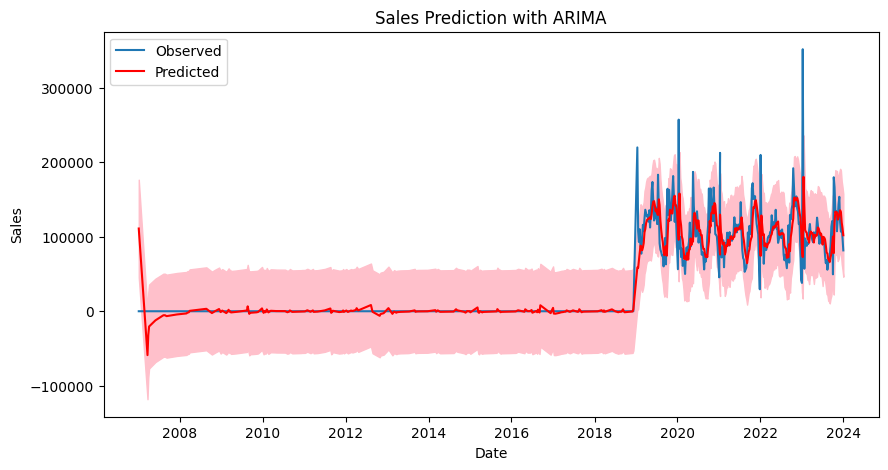

In [74]:
# ARIMA 모델 적합
# p, d, q 값은 ACF와 PACF 플롯을 보고 결정합니다.
model = SARIMAX(merged_data['Sales.Actual'], 
                exog=merged_data[['New_Store', 'Closed_Store']], 
                order=(1, 1, 1), 
                seasonal_order=(0, 0, 0, 0))

results = model.fit()

# 결과 요약
print(results.summary())

# 예측 수행
# 예측을 시작할 날짜를 데이터프레임의 인덱스 중 하나로 설정
start_date = merged_data.index[0]  # 첫 번째 날짜로 설정
pred = results.get_prediction(start=start_date, dynamic=False)
pred_conf = pred.conf_int()

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(merged_data['Sales.Actual'], label='Observed')
plt.plot(pred.predicted_mean, label='Predicted', color='r')
plt.fill_between(pred_conf.index, 
                 pred_conf.iloc[:, 0], 
                 pred_conf.iloc[:, 1], color='pink')
plt.title('Sales Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

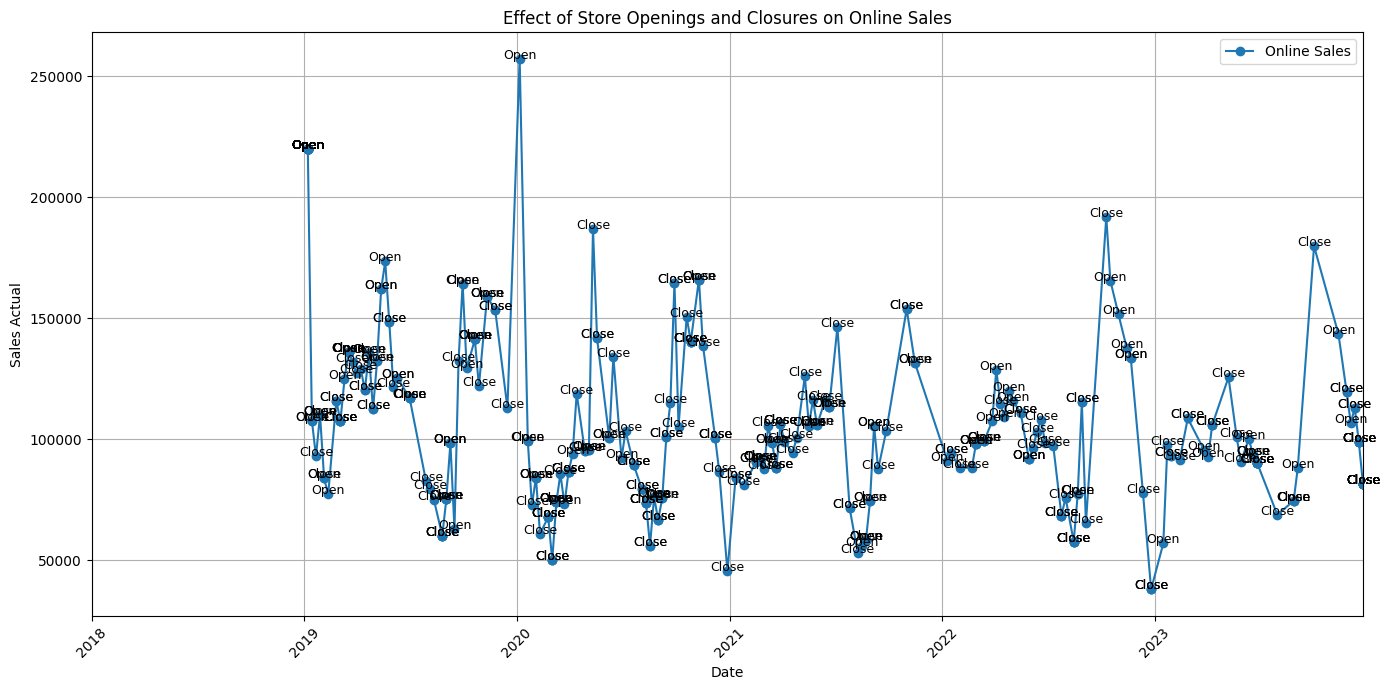

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 개업일과 폐업일에 대한 이벤트 생성
events = []

# 개업 이벤트 추가
for idx, row in offline_store_info.iterrows():
    events.append({'date': row['Open_Store_Week0'], 'event': 'Open', 'store': row['Off.Store.Name2']})

# 폐업 이벤트 추가
for idx, row in offline_store_info.iterrows():
    if pd.notna(row['Close_Store_Week0']):  # 폐업일이 존재하는 경우에만 추가
        events.append({'date': row['Close_Store_Week0'], 'event': 'Close', 'store': row['Off.Store.Name2']})

# 이벤트 데이터프레임 생성
events_df = pd.DataFrame(events)

# 데이터 형식 확인 및 변환
events_df['date'] = events_df['date'].astype(str).str.replace('.0', '')  # 소수점 제거
events_df['date'] = events_df['date'].astype(int)  # 정수로 변환

# 주 번호를 날짜로 변환하는 함수
def week_to_date(year_week):
    year = int(str(year_week)[:4])  # 연도 추출
    week = int(str(year_week)[4:])   # 주 번호 추출

    # 주 번호를 두 자리로 변환
    week_str = f'{week:02d}'  # 주 번호를 두 자리 문자열로 변환
    return pd.to_datetime(f'{year}-W{week_str}-1', format='%Y-W%W-%w')  # 해당 연도의 첫 번째 날(월요일)

# 이벤트 날짜를 datetime 형식으로 변환
events_df['date'] = events_df['date'].apply(week_to_date)

# 온라인 매출 데이터의 Wk_Year를 날짜로 변환
online_sales_by_year['Wk_Year'] = online_sales_by_year['Wk_Year'].apply(week_to_date)

# 이벤트와 온라인 매출 데이터 병합
merged_df = pd.merge_asof(events_df.sort_values('date'), 
                           online_sales_by_year.sort_values('Wk_Year'), 
                           left_on='date', 
                           right_on='Wk_Year', 
                           direction='backward')

# 매출 변화량 계산
merged_df['Sales.Change'] = merged_df['Sales.Actual'].diff()

# 개업과 폐업 이벤트에 따른 매출 변화량 시각화
plt.figure(figsize=(14, 7))
plt.plot(merged_df['date'], merged_df['Sales.Actual'], marker='o', label='Online Sales')

# x축 시작 날짜 설정
plt.xlim(pd.Timestamp('2018-01-01'), merged_df['date'].max())  # 2010년 1월 1일부터 시작

# 이벤트 표시
for i, row in merged_df.iterrows():
    plt.text(row['date'], row['Sales.Actual'], row['event'], fontsize=9, ha='center')

plt.title('Effect of Store Openings and Closures on Online Sales')
plt.xlabel('Date')
plt.ylabel('Sales Actual')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
